<a href="https://colab.research.google.com/github/duwi27sulis/Peramalan-LSTM_75-25/blob/main/Revnb_75_25_Update_H1_T3_Fix_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [2]:
# Package
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import optuna
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [3]:
# Fix random seed for reproducibility
tf.random.set_seed(10)
plt.rcParams['figure.figsize'] = (12,6)

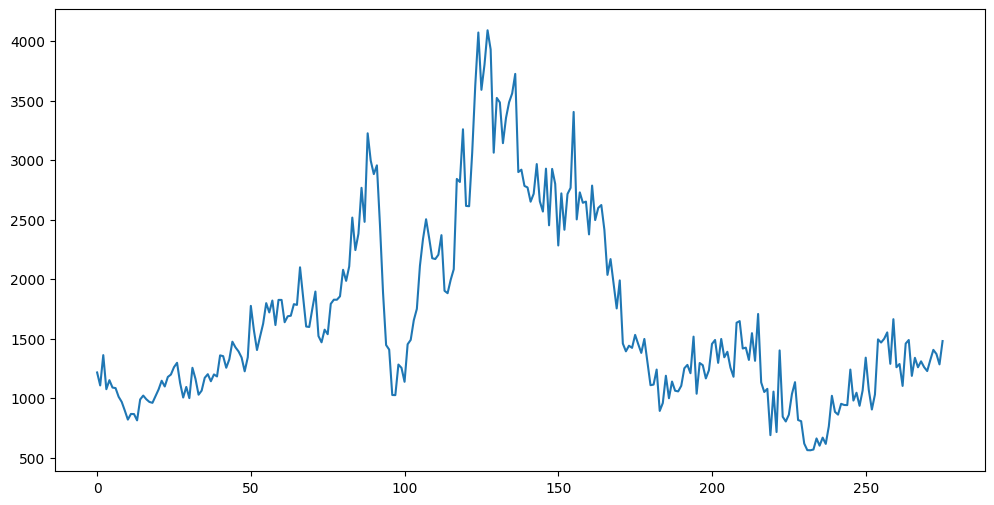

In [4]:
# Input Data
url = "https://raw.githubusercontent.com/duwi27sulis/Analisis_Data_LSTM/main/Ekspor-Migas-2001-2023.csv"
df = pd.read_csv(url, sep=",")
df['Tanggal'] = pd.to_datetime(df.Tanggal)
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')
plt.plot(dataset)

In [5]:
# Pembagian data
#train_size = int(len(dataset)*0.75)
train_size = 207
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [6]:
time_steps = 3
last_row_train = train[-time_steps:]
test = np.concatenate([last_row_train, test], axis=0)

In [7]:
ytest = test
ytrain = train

In [8]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit(dataset)

train = scaled_data.transform(train)
test = scaled_data.transform(test)

In [9]:
# Fungsi untuk membuat dataset
def create_dataset (X, y, time_steps = time_steps):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

In [10]:
X_test, y_test = create_dataset(test, test)
X_train, y_train = create_dataset(train, train)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (204, 3, 1)
y_train.shape:  (204, 1)
X_test.shape:  (69, 3, 1)
y_test.shape:  (69, 1)


In [11]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
# Define early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=20)

In [13]:
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_categorical('lstm_units', [32, 64, 128])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.1, 0.2, 0.3, 0.4, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 1e-2, 1e-1])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = trial.suggest_int('epochs', 50, 200, 50)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Cross-validation scores
    cv_scores = []

    for fold_index, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Build the model
        model = Sequential([
            LSTM(units=lstm_units, input_shape=(X_train_fold.shape[1], 1)),
            Dropout(dropout_rate),
            Dense(1)
        ])

        # Select optimizer
        if optimizer_name == 'Adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'RMSprop':
            optimizer = RMSprop(learning_rate=learning_rate)
        else:
            optimizer = SGD(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')

        # Fit the model
        history = model.fit(X_train_fold, y_train_fold,
                            validation_data=(X_val_fold, y_val_fold),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping],
                            verbose=0)

        # Evaluate the model
        val_pred = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, val_pred)
        cv_scores.append(mse)

        # Print MSE for each fold
        print(f"Fold {fold_index + 1}: MSE = {mse:.4f}")

    # Print average MSE across all folds
    print(f"Average MSE: {np.mean(cv_scores):.4f}")

    return np.mean(cv_scores)

In [14]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best parameters
print('Best parameters:', study.best_params)
print('Best value:', study.best_value)

[I 2024-08-15 05:10:32,625] A new study created in memory with name: no-name-d3590eb7-23ad-4713-957c-6d0580c099e9


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Fold 1: MSE = 0.0213
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Fold 2: MSE = 0.0552


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 3: MSE = 0.1328
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 4: MSE = 0.0084
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[I 2024-08-15 05:10:53,957] Trial 0 finished with value: 0.04452953860163689 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.04452953860163689.


Fold 5: MSE = 0.0050
Average MSE: 0.0445
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Fold 1: MSE = 0.0269
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0401
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Fold 3: MSE = 0.1839
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Fold 4: MSE = 0.0305
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


[I 2024-08-15 05:11:10,095] Trial 1 finished with value: 0.06081465631723404 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.04452953860163689.


Fold 5: MSE = 0.0226
Average MSE: 0.0608
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 1: MSE = 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.0364
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Fold 3: MSE = 0.0812
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 4: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-15 05:11:32,248] Trial 2 finished with value: 0.03460461646318436 and parameters: {'lstm_units': 32, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.03460461646318436.


Fold 5: MSE = 0.0254
Average MSE: 0.0346
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 1: MSE = 0.0287
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0977
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 3: MSE = 0.0943
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0336
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


[I 2024-08-15 05:11:54,453] Trial 3 finished with value: 0.0517948754131794 and parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 2 with value: 0.03460461646318436.


Fold 5: MSE = 0.0047
Average MSE: 0.0518
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Fold 1: MSE = 0.0206
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0144
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 3: MSE = 0.0229
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 4: MSE = 0.0064
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-15 05:12:15,214] Trial 4 finished with value: 0.013634520582854748 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.013634520582854748.


Fold 5: MSE = 0.0039
Average MSE: 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0256
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 2: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 3: MSE = 0.0301
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
Fold 4: MSE = 0.0064
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-15 05:12:37,857] Trial 5 finished with value: 0.01551713328808546 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.013634520582854748.


Fold 5: MSE = 0.0020
Average MSE: 0.0155
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Fold 1: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0117
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


[I 2024-08-15 05:13:05,505] Trial 6 finished with value: 0.00794102530926466 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0079
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0870
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 2: MSE = 0.1544
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 3: MSE = 0.4011
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.2536
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


[I 2024-08-15 05:13:23,606] Trial 7 finished with value: 0.18422594666481018 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 150, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0251
Average MSE: 0.1842
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 1: MSE = 0.0219
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Fold 2: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-15 05:13:46,940] Trial 8 finished with value: 0.012315881438553333 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0123
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
Fold 1: MSE = 0.0169
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 2: MSE = 0.0196
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 3: MSE = 0.0377
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0065
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2024-08-15 05:14:12,243] Trial 9 finished with value: 0.017076881602406502 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0047
Average MSE: 0.0171
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Fold 1: MSE = 0.0199
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 2: MSE = 0.0099
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Fold 3: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Fold 4: MSE = 0.0067
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


[I 2024-08-15 05:14:34,451] Trial 10 finished with value: 0.010802283883094788 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0023
Average MSE: 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 1: MSE = 0.0191
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Fold 2: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0166
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


[I 2024-08-15 05:14:56,856] Trial 11 finished with value: 0.01072479598224163 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0019
Average MSE: 0.0107
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 1: MSE = 0.0205
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 3: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


[I 2024-08-15 05:15:23,037] Trial 12 finished with value: 0.010771306231617928 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0025
Average MSE: 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 1: MSE = 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step
Fold 3: MSE = 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


[I 2024-08-15 05:15:45,839] Trial 13 finished with value: 0.008847145363688469 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0019
Average MSE: 0.0088
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 3: MSE = 0.0152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-08-15 05:16:12,289] Trial 14 finished with value: 0.009548378176987171 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0018
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 1: MSE = 0.0196
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 2: MSE = 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Fold 3: MSE = 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-15 05:16:39,877] Trial 15 finished with value: 0.010454261675477028 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0022
Average MSE: 0.0105
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 1: MSE = 0.0192
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 2: MSE = 0.0104
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Fold 3: MSE = 0.0178
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-15 05:17:04,675] Trial 16 finished with value: 0.011050905101001263 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0021
Average MSE: 0.0111
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0149
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 2: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Fold 3: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2024-08-15 05:17:33,409] Trial 17 finished with value: 0.009518944658339024 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0020
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 1: MSE = 0.0182
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 2: MSE = 0.0545
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.0918
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 4: MSE = 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


[I 2024-08-15 05:17:54,327] Trial 18 finished with value: 0.036306530237197876 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0073
Average MSE: 0.0363
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 1: MSE = 0.0279
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step
Fold 2: MSE = 0.0666
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 3: MSE = 0.1168
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Fold 4: MSE = 0.0102
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-15 05:18:15,601] Trial 19 finished with value: 0.04532358795404434 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0052
Average MSE: 0.0453
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 1: MSE = 0.0142
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 3: MSE = 0.0145
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0058
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-15 05:18:40,984] Trial 20 finished with value: 0.00918916892260313 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0018
Average MSE: 0.0092
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 1: MSE = 0.0156
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 2: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 3: MSE = 0.0160
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 4: MSE = 0.0061
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-15 05:19:08,979] Trial 21 finished with value: 0.009803809225559235 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0016
Average MSE: 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Fold 1: MSE = 0.0220
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Fold 2: MSE = 0.0108
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0150
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-08-15 05:19:36,775] Trial 22 finished with value: 0.011019885540008545 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0016
Average MSE: 0.0110
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Fold 1: MSE = 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 2: MSE = 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 3: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Fold 4: MSE = 0.0073
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-08-15 05:20:01,751] Trial 23 finished with value: 0.009521521627902985 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0015
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 1: MSE = 0.0161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 2: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 3: MSE = 0.0136
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Fold 4: MSE = 0.0056
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-08-15 05:20:27,313] Trial 24 finished with value: 0.00932474248111248 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0018
Average MSE: 0.0093
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 1: MSE = 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Fold 2: MSE = 0.0122
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Fold 3: MSE = 0.0262
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 4: MSE = 0.0059
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[I 2024-08-15 05:20:54,074] Trial 25 finished with value: 0.011284852400422096 and parameters: {'lstm_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0019
Average MSE: 0.0113
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Fold 1: MSE = 0.0147
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 2: MSE = 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 3: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 4: MSE = 0.0063
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


[I 2024-08-15 05:21:20,998] Trial 26 finished with value: 0.009366809390485287 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Fold 1: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 2: MSE = 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 3: MSE = 0.0129
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


[I 2024-08-15 05:21:47,113] Trial 27 finished with value: 0.008725356310606003 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Fold 1: MSE = 0.0307
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 2: MSE = 0.1885
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 3: MSE = 0.1773
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 4: MSE = 0.0634
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-08-15 05:22:08,910] Trial 28 finished with value: 0.09235839545726776 and parameters: {'lstm_units': 64, 'dropout_rate': 0.1, 'learning_rate': 0.1, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0019
Average MSE: 0.0924
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 1: MSE = 0.0923
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 2: MSE = 0.1683
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Fold 3: MSE = 0.3255
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.2838
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


[I 2024-08-15 05:22:24,939] Trial 29 finished with value: 0.17731496691703796 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0166
Average MSE: 0.1773
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Fold 1: MSE = 0.0273
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
Fold 2: MSE = 0.0698
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Fold 3: MSE = 0.1257
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Fold 4: MSE = 0.0112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


[I 2024-08-15 05:22:42,274] Trial 30 finished with value: 0.04776108264923096 and parameters: {'lstm_units': 32, 'dropout_rate': 0.4, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0048
Average MSE: 0.0478
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 1: MSE = 0.0157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 2: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0140
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


[I 2024-08-15 05:23:13,795] Trial 31 finished with value: 0.009435633197426796 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Fold 1: MSE = 0.0154
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
Fold 2: MSE = 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Fold 3: MSE = 0.0134
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 4: MSE = 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-08-15 05:23:41,726] Trial 32 finished with value: 0.009493621066212654 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 1: MSE = 0.0161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 2: MSE = 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 3: MSE = 0.0138
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Fold 4: MSE = 0.0060
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


[I 2024-08-15 05:24:08,464] Trial 33 finished with value: 0.00949811190366745 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0018
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 1: MSE = 0.0163
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Fold 2: MSE = 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 3: MSE = 0.0153
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 420ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


[I 2024-08-15 05:24:34,769] Trial 34 finished with value: 0.009806069545447826 and parameters: {'lstm_units': 128, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0016
Average MSE: 0.0098
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0228
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Fold 2: MSE = 0.0115
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 3: MSE = 0.0236
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 4: MSE = 0.0070
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


[I 2024-08-15 05:24:58,683] Trial 35 finished with value: 0.013327973894774914 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0133
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 1: MSE = 0.0148
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0253
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 3: MSE = 0.0366
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 4: MSE = 0.0130
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


[I 2024-08-15 05:25:19,019] Trial 36 finished with value: 0.018557872623205185 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 50, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0031
Average MSE: 0.0186
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Fold 1: MSE = 0.0402
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step
Fold 2: MSE = 0.0785
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Fold 3: MSE = 0.1772
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Fold 4: MSE = 0.0411
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2024-08-15 05:25:44,503] Trial 37 finished with value: 0.07363991439342499 and parameters: {'lstm_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0311
Average MSE: 0.0736
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 1: MSE = 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Fold 2: MSE = 0.0355
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 3: MSE = 0.0436
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Fold 4: MSE = 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


[I 2024-08-15 05:26:08,476] Trial 38 finished with value: 0.022626968100667 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0172
Average MSE: 0.0226
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step
Fold 1: MSE = 0.0212
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Fold 2: MSE = 0.0184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Fold 3: MSE = 0.0434
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 4: MSE = 0.0087
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


[I 2024-08-15 05:26:33,079] Trial 39 finished with value: 0.01866336539387703 and parameters: {'lstm_units': 128, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 128, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0187
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 1: MSE = 0.0492
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Fold 2: MSE = 0.0807
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Fold 3: MSE = 0.0767
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 4: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


[I 2024-08-15 05:26:55,705] Trial 40 finished with value: 0.046327121555805206 and parameters: {'lstm_units': 64, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 32, 'epochs': 150, 'optimizer': 'RMSprop'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0105
Average MSE: 0.0463
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Fold 1: MSE = 0.0201
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Fold 2: MSE = 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 3: MSE = 0.0144
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0069
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


[I 2024-08-15 05:27:21,537] Trial 41 finished with value: 0.010616330429911613 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0016
Average MSE: 0.0106
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Fold 1: MSE = 0.0170
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step
Fold 2: MSE = 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Fold 3: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


[I 2024-08-15 05:27:47,492] Trial 42 finished with value: 0.009594382718205452 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0020
Average MSE: 0.0096
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Fold 1: MSE = 0.0157
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Fold 2: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Fold 3: MSE = 0.0139
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
Fold 4: MSE = 0.0062
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


[I 2024-08-15 05:28:20,981] Trial 43 finished with value: 0.009455898776650429 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0018
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 1: MSE = 0.0151
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 2: MSE = 0.0094
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Fold 3: MSE = 0.0153
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


[I 2024-08-15 05:28:51,836] Trial 44 finished with value: 0.00946851633489132 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 100, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0018
Average MSE: 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Fold 1: MSE = 0.0196
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step
Fold 2: MSE = 0.0097
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Fold 3: MSE = 0.0143
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


[I 2024-08-15 05:29:19,191] Trial 45 finished with value: 0.010320678353309631 and parameters: {'lstm_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0023
Average MSE: 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Fold 1: MSE = 0.0195
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
Fold 2: MSE = 0.0100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Fold 3: MSE = 0.0146
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Fold 4: MSE = 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


[I 2024-08-15 05:29:44,723] Trial 46 finished with value: 0.010339456610381603 and parameters: {'lstm_units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 50, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0019
Average MSE: 0.0103
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Fold 1: MSE = 0.0166
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step
Fold 2: MSE = 0.0701
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Fold 3: MSE = 0.2158
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Fold 4: MSE = 0.0272
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


[I 2024-08-15 05:30:06,600] Trial 47 finished with value: 0.0690751001238823 and parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.001, 'batch_size': 128, 'epochs': 200, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0157
Average MSE: 0.0691
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Fold 1: MSE = 0.0184
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Fold 2: MSE = 0.0095
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step
Fold 3: MSE = 0.0131
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 4: MSE = 0.0075
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


[I 2024-08-15 05:30:32,280] Trial 48 finished with value: 0.010056815110147 and parameters: {'lstm_units': 128, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0017
Average MSE: 0.0101
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Fold 1: MSE = 0.0504
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Fold 2: MSE = 0.0884
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Fold 3: MSE = 0.2649
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Fold 4: MSE = 0.0528
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[I 2024-08-15 05:30:49,044] Trial 49 finished with value: 0.09542285650968552 and parameters: {'lstm_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 100, 'optimizer': 'SGD'}. Best is trial 6 with value: 0.00794102530926466.


Fold 5: MSE = 0.0207
Average MSE: 0.0954
Best parameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 150, 'optimizer': 'Adam'}
Best value: 0.00794102530926466


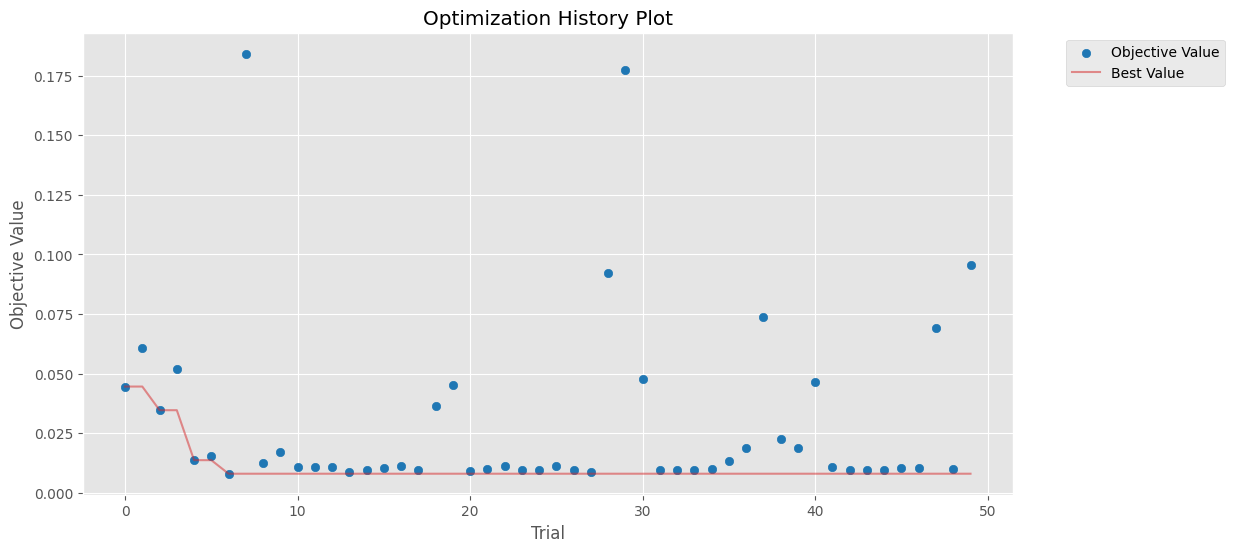

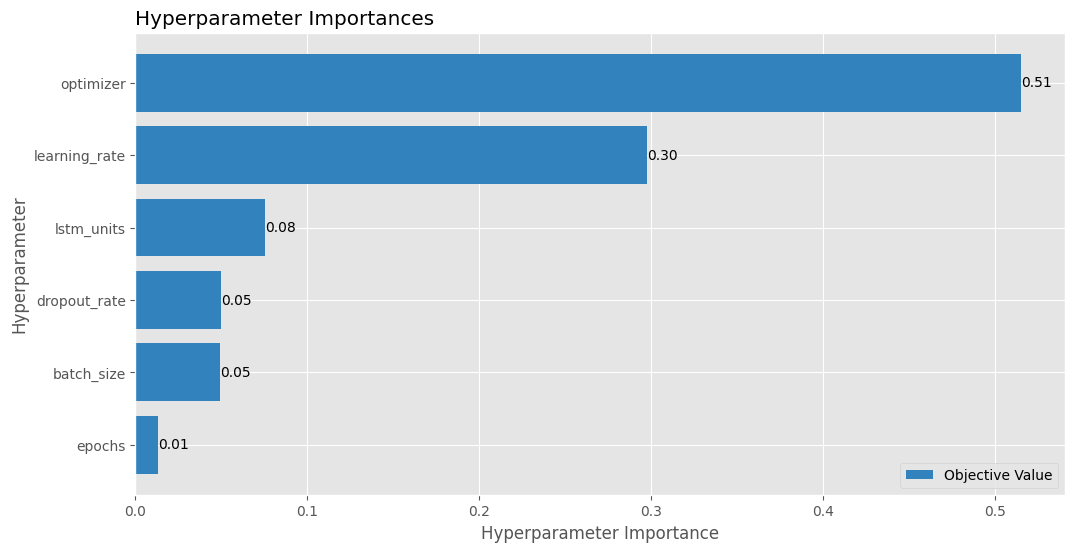

In [15]:
# Plot optimization history and parameter importances
plot_optimization_history(study)
plt.show()
plot_param_importances(study)
plt.show()

In [16]:
# Train final model with best parameters
best_params = study.best_params
model = Sequential([
    LSTM(units=best_params['lstm_units'], input_shape=(X_train.shape[1], 1)),
    Dropout(best_params['dropout_rate']),
    Dense(1)
])

# Select optimizer based on best parameters
if best_params['optimizer'] == 'Adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
elif best_params['optimizer'] == 'RMSprop':
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_params['learning_rate'])

model.compile(optimizer=optimizer, loss='mse')

# Train the model on the full training dataset
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

Epoch 1/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.1058 - val_loss: 0.0577
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0356 - val_loss: 0.0030
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - val_loss: 0.0020
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0138 - val_loss: 0.0145
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0123 - val_loss: 0.0042
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0093 - val_loss: 0.0021
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0080 - val_loss: 0.0048
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - val_loss: 0.0029
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0080 - val_loss: 0.0027
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0065 - val_lo

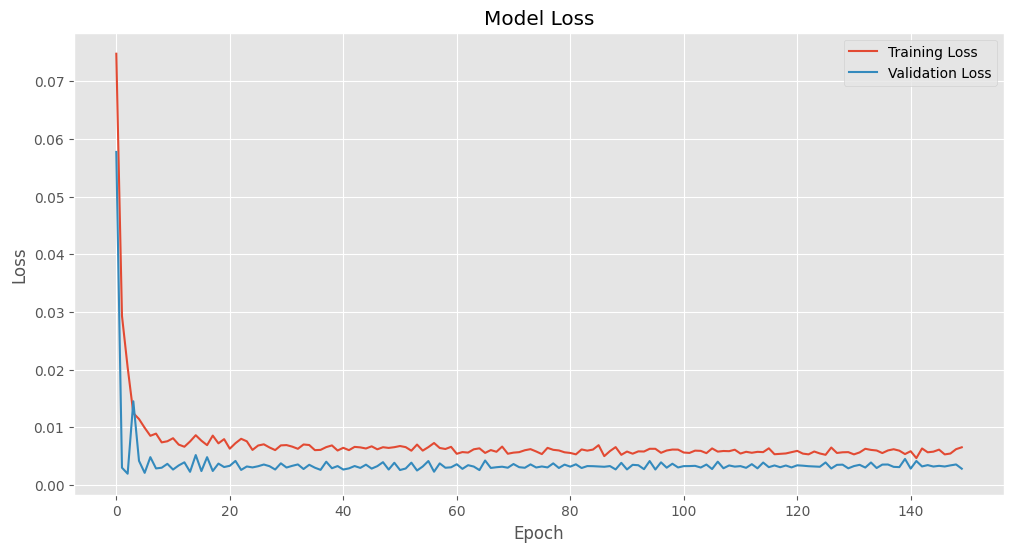

Average Loss: 0.0070


In [17]:
# Fungsi untuk plot training dan validation loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

plot_loss(history)

average_loss = np.mean(history.history['loss'])
print(f"Average Loss: {average_loss:.4f}")

In [18]:
# Make predictions on the training and testing datasets
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [19]:
# Inverse transform predictions and actual values
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

In [20]:
# Define a function to calculate MAE, MAPE, and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.3f}%'.format(mape))
    print('')

In [21]:
# Evaluasi Model for Training Data
evaluate_prediction(train_predictions, y_train_actual, 'evaluasi model data train')

# Evaluasi Model for Testing Data
evaluate_prediction(test_predictions, y_test_actual, 'evaluasi model data test')

evaluasi model data train:
Mean Absolute Error: 180.546
Root Mean Square Error: 246.542
Mean Absolute Percentage Error: 9.637%

evaluasi model data test:
Mean Absolute Error: 173.526
Root Mean Square Error: 216.486
Mean Absolute Percentage Error: 16.012%



In [22]:
date_train = df['Tanggal'][time_steps:len(y_train_actual) + time_steps]
date_test = df['Tanggal'][-len(y_test_actual):]

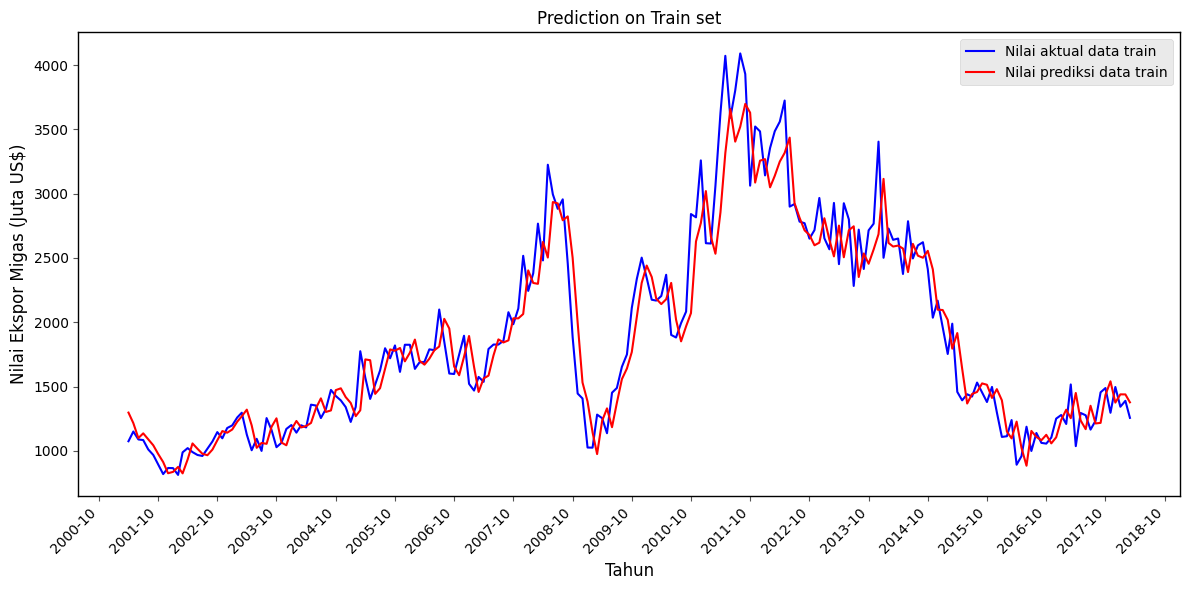

In [23]:
import matplotlib.dates as mdates
# Visualisasi prediksi vs aktual on train data
plt.figure(figsize=(12,6))
plt.title('Prediction on Train set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_train, y_train_actual, label='Nilai aktual data train', color='blue')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train', color='red')
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

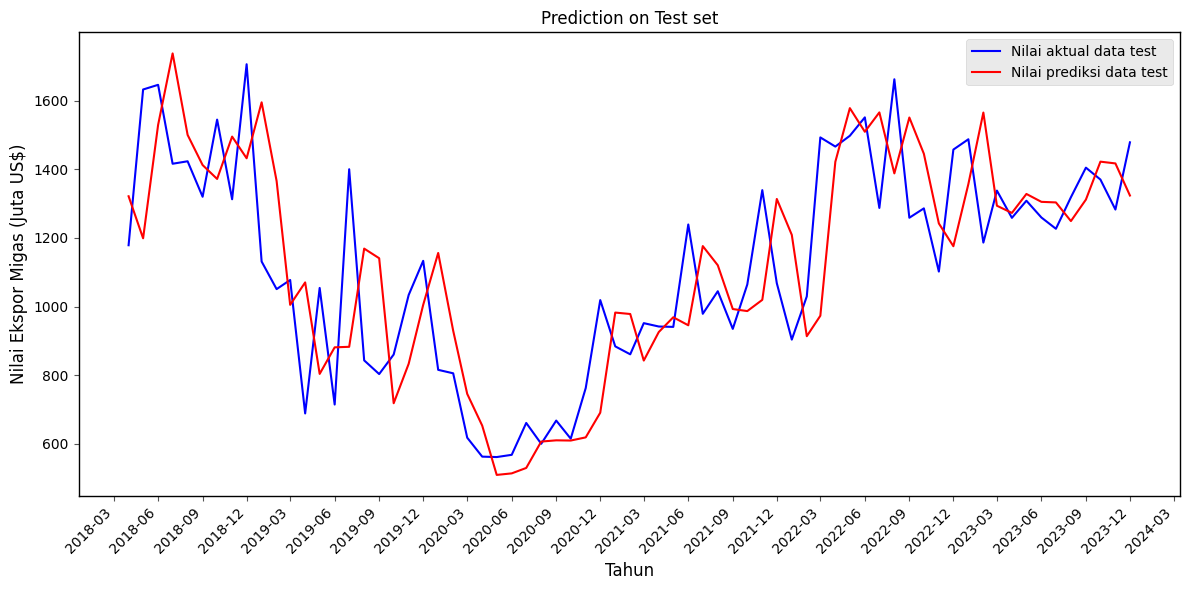

In [24]:
# Visualisasi prediksi vs aktual on test data
plt.figure(figsize=(12,6))
plt.title('Prediction on Test set', fontsize=12)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test', color='blue')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test', color='red')

# Mengatur format tanggal
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate dates for better visibility
plt.xticks(rotation=45)  # Memutar label x-axis agar lebih mudah dibaca
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

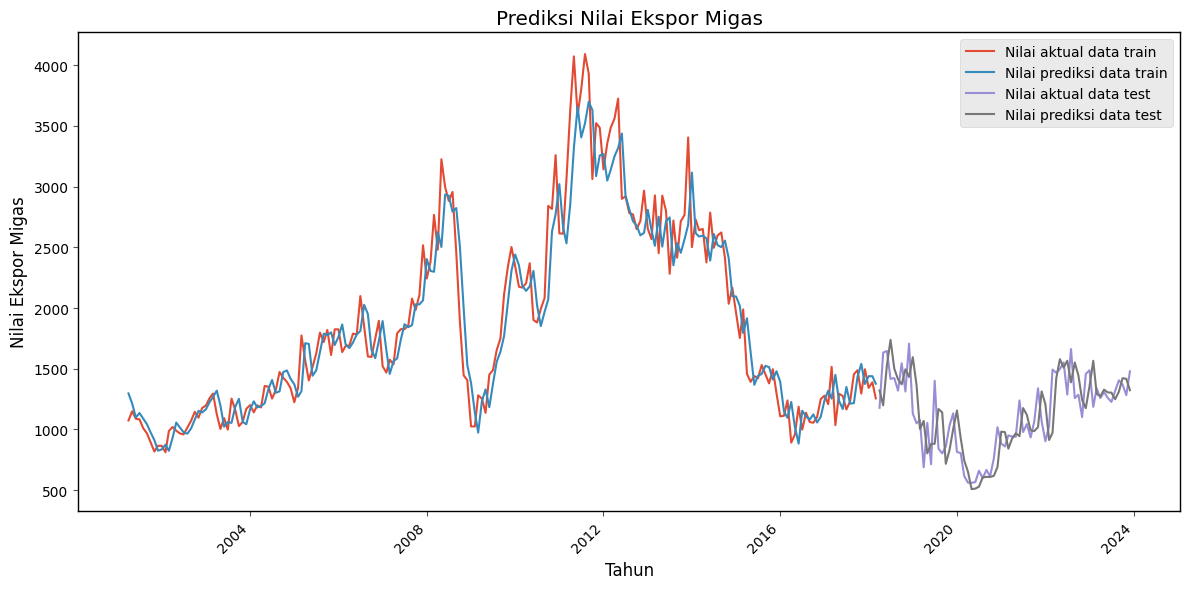

In [25]:
# Plot results
plt.figure(figsize=(12,6))
plt.plot(date_train, y_train_actual, label='Nilai aktual data train')
plt.plot(date_train, train_predictions, label='Nilai prediksi data train')
plt.plot(date_test, y_test_actual, label='Nilai aktual data test')
plt.plot(date_test, test_predictions, label='Nilai prediksi data test')
plt.title('Prediksi Nilai Ekspor Migas')
plt.xlabel('Tahun', color='black')
plt.ylabel('Nilai Ekspor Migas', color='black')
plt.legend(fontsize=10)
plt.legend()
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
      Tanggal  Nilai Ekspor Migas (Peramalan)
0  2024-01-01                     1438.646973
1  2024-02-01                     1504.786011
2  2024-03-01                     1505.660278
3  2024-04-01                     1539.121338
4  2024-05-01                     1554.041138
5  2024-06-01                     1578.093018
6  2024-07-01                     1596.639526
7  2024-08-01                     1617.380249
8  2024-09-01                     1636.215942
9  2024-10-01                     1655.235107
10 2024-11-01                     1673

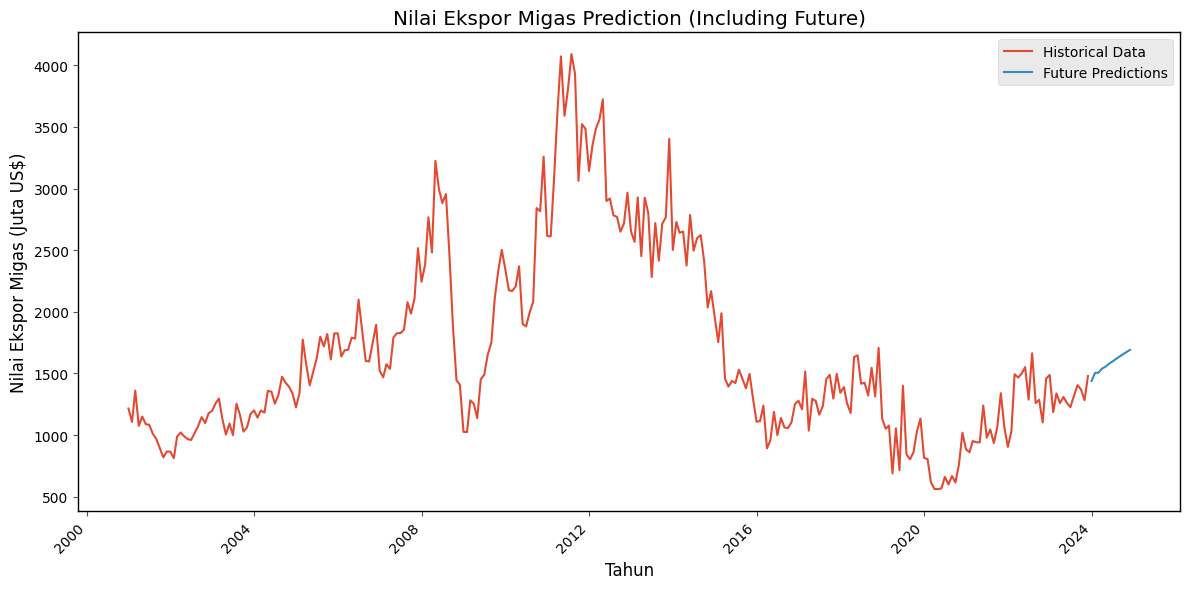

In [26]:
scaled_dt = scaler.fit_transform(dataset)

# Fungsi untuk melakukan peramalan
def forecast_future(model, last_data, periods, scaler):
    future_predictions = []
    current_batch = last_data

    for _ in range(periods):
        # Prediksi satu langkah ke depan
        current_pred = model.predict(current_batch)
        future_predictions.append(current_pred[0])

        # Update batch untuk prediksi berikutnya
        current_batch = np.roll(current_batch, -1, axis=1)
        current_batch[0, -1, 0] = current_pred[0]

    # Inverse transform hasil peramalan
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return scaler.inverse_transform(future_predictions)

# Ambil data terakhir untuk input peramalan
last_known_data = scaled_dt[-time_steps:]
last_known_data = last_known_data.reshape((1, time_steps, 1))

# Lakukan peramalan untuk 12 periode ke depan
future_periods = 12
future_predictions = forecast_future(model, last_known_data, future_periods, scaler)

# Buat tanggal untuk hasil peramalan
last_date = df['Tanggal'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=30), periods=future_periods, freq='MS')

# Buat DataFrame untuk hasil peramalan
forecast_df = pd.DataFrame({
    'Tanggal': future_dates,
    'Nilai Ekspor Migas (Peramalan)': future_predictions.flatten()
})

print(forecast_df)

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(df['Tanggal'], df['Nilai Ekspor Migas'], label='Historical Data')
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.title('Nilai Ekspor Migas Prediction (Including Future)')
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')
plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()

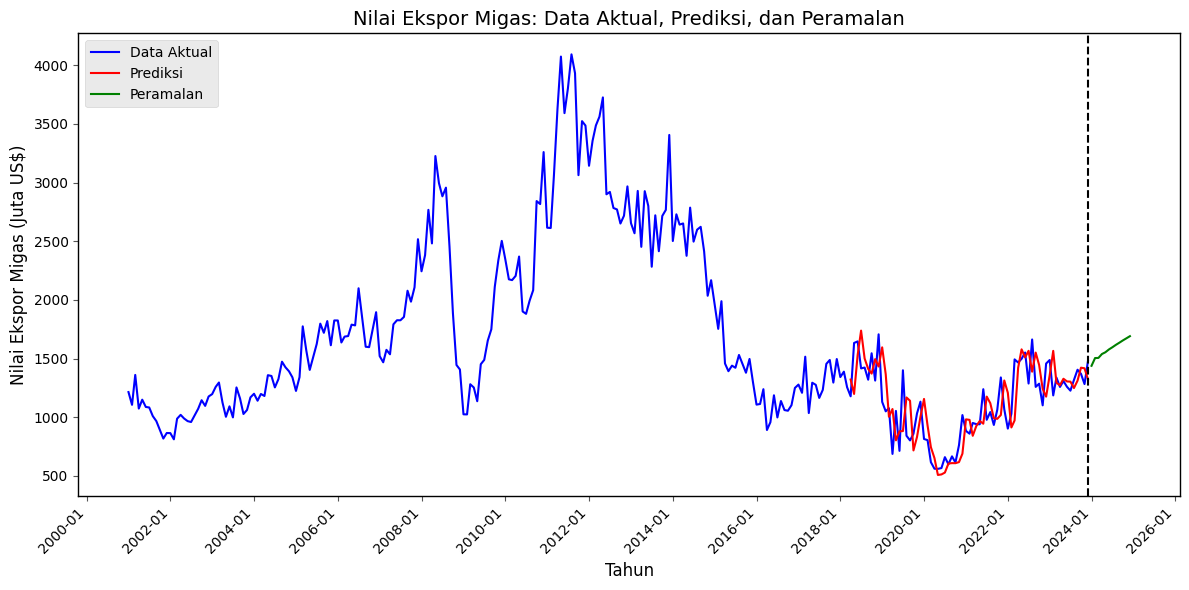

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Mengubah future_dates menjadi Series
future_dates_series = pd.Series(future_dates)

# Menggabungkan data aktual, prediksi data uji, dan hasil peramalan
all_dates = pd.concat([df['Tanggal'], future_dates_series])
all_actual = pd.concat([df['Nilai Ekspor Migas'], pd.Series([np.nan] * len(future_dates))])
all_predictions = np.concatenate([np.array([np.nan] * (len(df) - len(test_predictions))),
                                  test_predictions.flatten(),
                                  future_predictions.flatten()])

# Membuat plot
plt.figure(figsize=(12, 6))
plt.plot(all_dates, all_actual, label='Data Aktual', color='blue')

# Garis prediksi
plt.plot(all_dates[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         all_predictions[-len(test_predictions)-len(future_predictions):-len(future_predictions)],
         label='Prediksi', color='red')

# Garis peramalan
plt.plot(all_dates[-len(future_predictions):],
         all_predictions[-len(future_predictions):],
         label='Peramalan', color='green')

# Menambahkan garis vertikal untuk memisahkan data uji dan peramalan
split_date = df['Tanggal'].iloc[-1]
plt.axvline(x=split_date, color='black', linestyle='--')

plt.title('Nilai Ekspor Migas: Data Aktual, Prediksi, dan Peramalan', fontsize=14)
plt.xlabel('Tahun', fontsize=12, color='black')
plt.ylabel('Nilai Ekspor Migas (Juta US$)', fontsize=12, color='black')

# Mengatur format tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))

plt.xticks(rotation=45, ha='right', color='black')
plt.yticks(color='black')
plt.legend(fontsize=10)

# Mengatur latar belakang putih dan menghapus grid
plt.gca().set_facecolor('white')
plt.grid(False)

# Mengatur garis tepi
for spine in plt.gca().spines.values():
    spine.set_edgecolor('black')

plt.tight_layout()
plt.show()

In [28]:
!pip install openpyxl

In [34]:
forecast_df.to_excel('forecast_75:25_h1t3.xlsx', index=False)
from google.colab import files
files.download('forecast_75:25_h1t3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
import numpy as np
import pandas as pd

# Konversi y_train_actual, train_predictions, y_test_actual, dan test_predictions ke array satu dimensi
y_train_actual = np.array(y_train_actual).flatten()
train_predictions = np.array(train_predictions).flatten()
y_test_actual = np.array(y_test_actual).flatten()
test_predictions = np.array(test_predictions).flatten()

# Buat DataFrame untuk nilai aktual dan prediksi data train
# Membuat DataFrame hasil untuk training dan testing
train_df = pd.DataFrame({
    'Tanggal': date_train.reset_index(drop=True),
    'Data Aktual': y_train_actual,
    'Data Prediksi': train_predictions
})

# Buat DataFrame untuk nilai aktual dan prediksi data test
test_df = pd.DataFrame({
    'Tanggal': date_test.reset_index(drop=True),
    'Data Aktual': y_test_actual,
    'Data Prediksi': test_predictions
})

# Gabungkan train_df dan test_df menjadi satu DataFrame
prediksi_df = pd.concat([train_df, test_df])

# Simpan DataFrame ke dalam file Excel
prediksi_df.to_excel('prediksi_75:25_h1t3.xlsx', index=False)

# Jika Anda menggunakan Google Colab, Anda dapat mengunduh file Excel
from google.colab import files
files.download('prediksi_75:25_h1t3.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>